In [1]:
import pandas as pd   #import all the libraries
import numpy as np
import seaborn as sns
import warnings

from statsmodels.formula.api import ols #stat libraries
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot
import matplotlib.pyplot as plt

from scipy import stats 
%matplotlib inline
warnings.filterwarnings('ignore')


In [2]:
users = pd.read_csv("./users.csv")
meds = pd.read_csv("./medication.csv", infer_datetime_format=True)
bp = pd.read_csv("./blood_pressure[1].csv", infer_datetime_format=True) #load data as dataframes


#### For further analysis the dtasets need to be merged, the user id feature can be used to establish links between the datasets.

#### I have also created a new feature for each patient, named percentage adherence, this indicates throughtout the treatment how what was the ration of medicines taken over prescribed dose. 0 indicating no medicines were taken and 1 indicates no doses were missed.


In [3]:
bp_meds = pd.merge(bp, meds, on = ["user_id", "date"])
pdata = pd.merge(bp_meds, users, on = ["user_id"])
pdata=pdata.replace({'sbp': {0: pdata["sbp"].median()}}) 
pdata=pdata.replace({'dbp': {0: pdata["dbp"].median()}}) 

temp= pdata.groupby(by="user_id").mean().reset_index()
temp=temp.rename(columns = {'pill_detect':'pct_adh'}) # new feature
pdata = pd.merge(pdata, temp.iloc[:,[0, 3]], on="user_id")



### Data Statisitics.

In [4]:
pdata.head() #this is how the data looks now 

,user_id,date,sbp,dbp,pill_detect,gender,bmi,pct_adh
0,100000,4/24/17,153.0,108.0,False,female,39,0.206897
1,100000,4/25/17,152.0,106.0,True,female,39,0.206897
2,100000,4/26/17,151.0,106.0,True,female,39,0.206897
3,100000,4/27/17,154.0,109.0,False,female,39,0.206897
4,100000,4/28/17,155.0,100.0,False,female,39,0.206897


#### Before proceeding with the analysis, understanding the distribution helps. From the distribution plots it can be observed that the blood pressure levels are fairly normal distributed. 


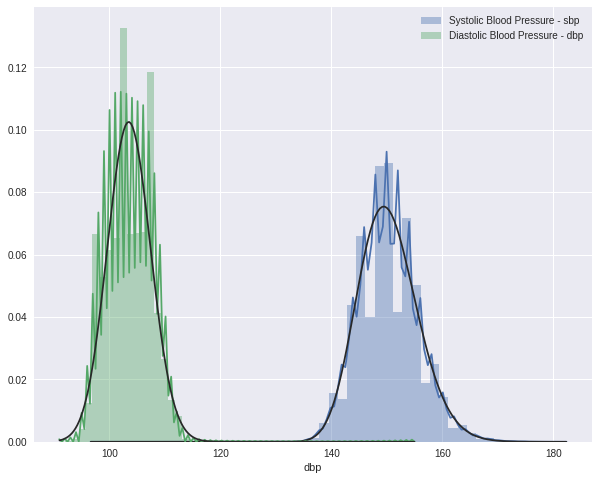

In [5]:
from scipy import stats
sns.set(rc={'figure.figsize':(10,8)})

sns.distplot(pdata.sbp, kde=True, fit=stats.gamma, label="Systolic Blood Pressure - sbp");
sns.distplot(pdata.dbp, kde=True , fit=stats.gamma, label="Diastolic Blood Pressure - dbp"); 

#fit - to approximate distributiom
plt.legend()

#### The mean adherence level; that is, looking at all the data, overall adehrence is 37%. 

In [6]:
np.sum(pdata.pill_detect)/len(pdata.pill_detect) ## percentage of times pill was detected 

0.37768178094166627

#### I was curious of the participants in the study, turns out male to female ratio is 1!

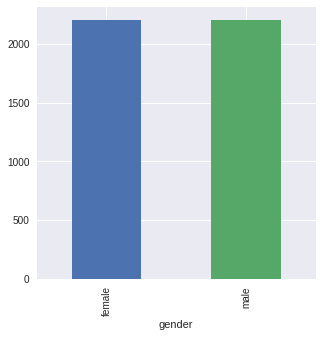

In [7]:
users.groupby(by="gender").count().iloc[:,1].plot(kind="bar",figsize=(5,5))

#### Does the day of week factor has any effect on adherence? 
#### Turns out there is no noticeable effect.

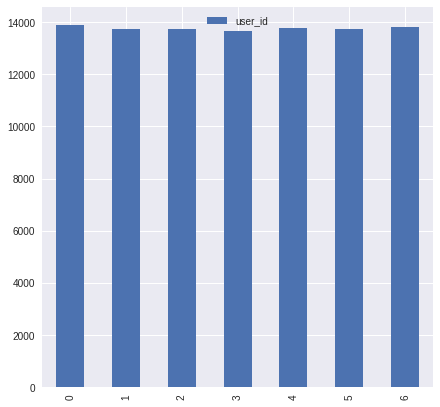

In [8]:
pdata["date"] = pd.to_datetime(pdata.date)
pdata["day"] = pdata["date"].dt.weekday_name
temp = pdata[pdata["pill_detect"] == True]
temp = temp.groupby(by="day").count().reset_index().iloc[:,1:2].plot(kind="bar",figsize=[7,7])
# So there is no noticeable effect of day on adherence 

### Part - 1 Is there a relationship between medical adherence (i.e., how often somebody takes their medicine) and blood pressure ? 

#### To answer the question above  is there a noticeable difference in mean bp levels for days when pills were taken vs Not?

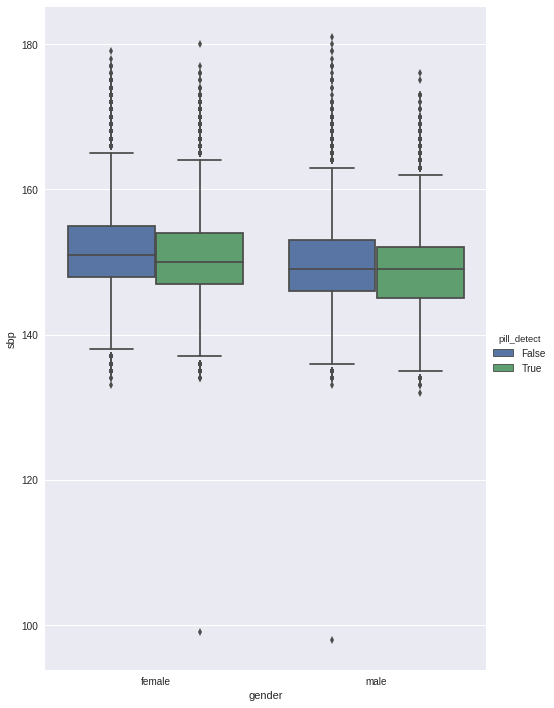

In [9]:
sns.factorplot(x="gender", y="sbp",
                    hue="pill_detect",
                    data=pdata, kind="box",
                    size=10, aspect=.7);

#### From the plot we can see that the mean blood pressure levels are lower when the people are taking the pills vs not
#### 

In [10]:
print(pdata[(pdata['pill_detect'] == True)].iloc[:,2:4].describe())
print(pdata[(pdata['pill_detect'] == False)].iloc[:,2:4].describe())

                sbp           dbp
count  96347.000000  96347.000000
mean     149.683695    103.384880
std        5.240394      3.875745
min       99.000000     92.000000
25%      146.000000    100.000000
50%      149.000000    103.000000
75%      153.000000    106.000000
max      180.000000    154.000000
                 sbp            dbp
count  158754.000000  158754.000000
mean      150.678855     103.733115
std         5.386989       3.897908
min        98.000000      93.000000
25%       147.000000     101.000000
50%       150.000000     104.000000
75%       154.000000     107.000000
max       181.000000     151.000000


In [11]:
users["pct_adh"] = pdata["pct_adh"]

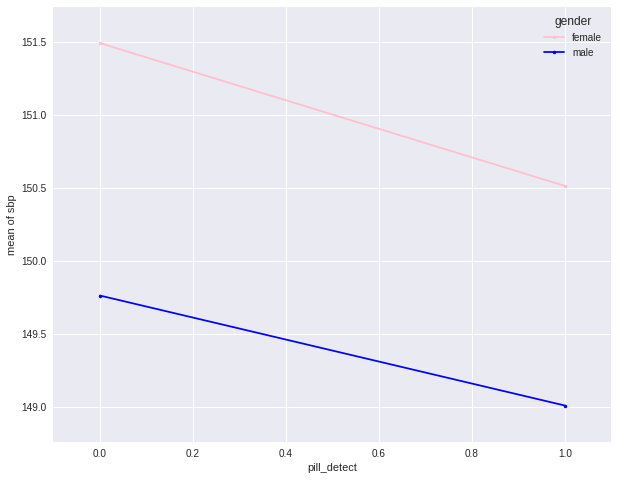

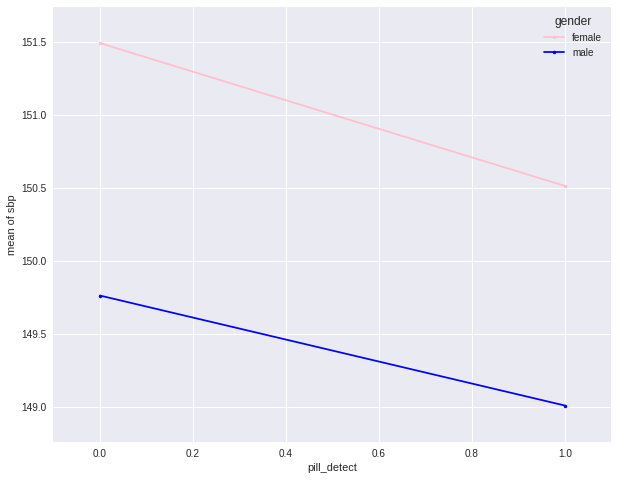

In [12]:
interaction_plot(pdata["pill_detect"], pdata["gender"], pdata["sbp"], func=np.mean,colors=['pink','blue'])

#### From the interaction plot we can see that the percentage adherence factor that we created earlier has an impact on blood pressure, lower level are on higher end whereas high adherence has low mean

#### To gather more stastical evidence, we can use anova analysis and linear model with response variable as blood pressure. 

In [13]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.stats.anova import anova_lm


interX_lm = ols("sbp ~ pct_adh", pdata.iloc[:,2:]).fit()
print(interX_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    sbp   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     5532.
Date:                Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                        02:49:41   Log-Likelihood:            -7.8725e+05
No. Observations:              255101   AIC:                         1.575e+06
Df Residuals:                  255099   BIC:                         1.575e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    152.0801      0.026   5828.170      0.0

#### From the model sumary we can see that the mean adherence feature has a stastical impact on patients blood pressure levels.
#### The magnitude of this impact can be upto 4.7 point change in blood pressure with a unit change in adherence. 

#### We can also use t test to strengthen our analysis, with the hypothesis, are the population with lower than .5 adherence is different than than the population with adherence higher than .5

In [14]:
low_adh = pdata[pdata['pct_adh'] < 0.5 ]['sbp']
high_adh = pdata[pdata['pct_adh'] > 0.5]['sbp']
stats.ttest_ind(low_adh, high_adh)
#stats.ttest_rel(pill_true, pill_false)


Ttest_indResult(statistic=51.948057912262392, pvalue=0.0)

#### and the answer is yes, the probability of both populations being similar is close to 0. 

#### We could also study this as a series, where over time with resampling for each user. This will help us see how the blood pressure for a patient(patient with low adherence vs patient with high adherence) changes over time.

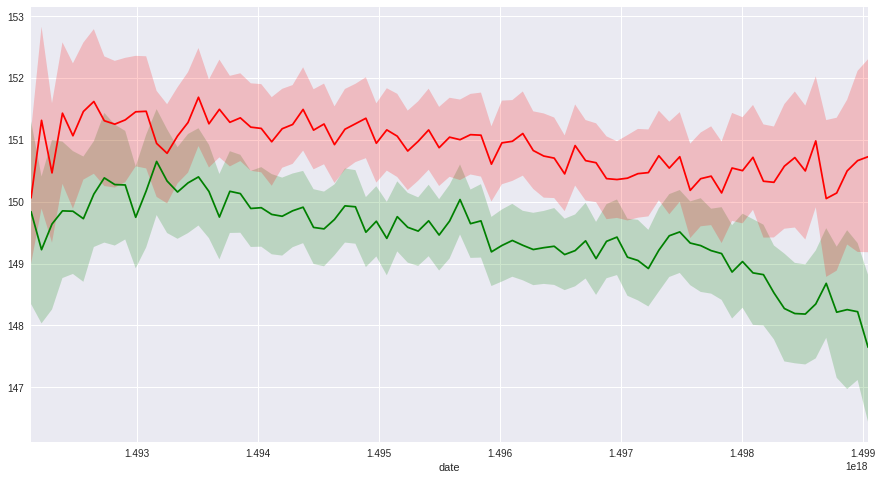

In [16]:
#dc.pivot(columns='disease_header', index='medicine', values='disease').reset_index()
pv_data = pdata.pivot(columns="user_id", index="date", values="sbp").reset_index()

pv_data.columns = pv_data.columns.astype(str)
pv_data.set_index("date", inplace=True)
pv_data.index = pd.to_datetime(pv_data.index)

usr_meds = pd.merge(users, meds, on = ["user_id"]);
user_adh = usr_meds.groupby(by=["user_id"]).mean()
user_adh.sort_values(by="pill_detect")

low_adh = list(user_adh[user_adh["pill_detect"] < 0.4].head(200).index) #low adheremce level
high_adh = list(user_adh[user_adh["pill_detect"] > 0.7].head(200).index) #high adherence levels
high_adh = [str(i) for i in list(high_adh)]
low_adh = [str(i) for i in list(low_adh)]
pv_data = pv_data[3:-5] ## too many missing values in first and last few days 

sns.set(rc={'figure.figsize':(15,8)})

sns.tsplot([pv_data[i] for i in high_adh], time=pv_data.index, estimator=np.nanmean, color="green", ci=[90]) #high adherence >80
sns.tsplot([pv_data[i] for i in low_adh], time=pv_data.index, estimator=np.nanmean, color="red",  ci=[90]) #low adherence <30

### red - low adherence , green high adherence

#### From the plot it is clear that pathent with high adherence have much better blood pressure levels at the end of the treatment than patients with low adherence. Even though both groups started at around same levels. 

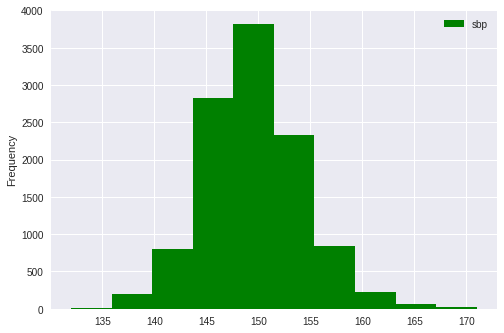

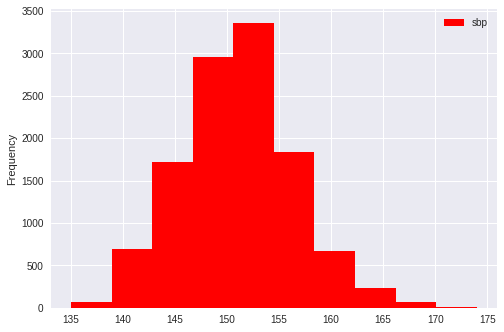

In [17]:
import numpy as np; np.random.seed(22)
import seaborn as sns; sns.set(color_codes=True)

data = pdata[(pdata.user_id.isin(high_adh) )].iloc[:,1:3]
data1 = pdata[(pdata.user_id.isin(low_adh) )].iloc[:,1:3]
data.set_index('date').plot(color ="green", kind="hist") ##Skewed to left - which is good
data1.set_index('date').plot(color ="red", kind="hist") ##Sekwed to right


#### Another way to understand this is using distributions of low and hight adherence individuals. We can clearly see that the high adherence distributions is left skewed - most of the values are on the lower side. Low adherence distribution is exact opposite.

## Part  - 2 Users has about 2 months of data, and some of those users have probably changed their medical adherence during that span of  this time. Do users that increase their  frequency see a change in blood pressure ? If so, how much does it change?

#### To answer this question, we need a much different representation of our data. I decided, to go with weekly adherence, this indicates, how many times a person has taken their medicine over the prescribed dosage.
#### For each day past 7 days adherence was calculated and used as a feature. The intention is that this number will indicate recent adherence and can be used to see the effect 

In [18]:
temp = pdata.groupby(by="user_id")['pill_detect'].apply(lambda x: x.shift().rolling(min_periods=1,window=7).mean()).reset_index(name="weekly_adh")
pdata["weekly_adh"] = temp["weekly_adh"] 

#### Now to understand, if it has an impact and what is the magnitude of this impact, a linear model was created, where the coefficient of the weekly adherence feature would indicate the impact.

In [20]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.stats.anova import anova_lm


interX_lm = ols("sbp ~ weekly_adh", pdata.iloc[:,2:]).fit()
print(interX_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    sbp   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     7341.
Date:                Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                        03:01:12   Log-Likelihood:            -7.7268e+05
No. Observations:              250692   AIC:                         1.545e+06
Df Residuals:                  250690   BIC:                         1.545e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    151.5167      0.018   8538.373      0.0

#### The weekly adherence has a significant impact (p-val ~ 0), and magnitude of this impact is upto 3 units in systolic blood pressure.

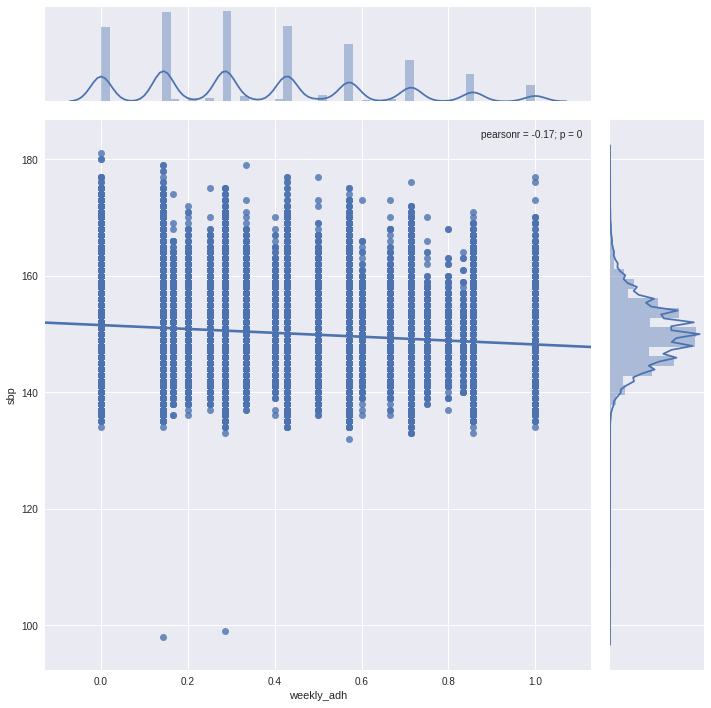

In [21]:
sns.set(rc={'figure.figsize':(18,12)})
#f, ax = plt.subplots(figsize=(5, 6))
sns.jointplot(x='weekly_adh', y='sbp',  data=pdata, size=10,kind="reg")

#### The plot suggests an inverse relation betwen weekly adherence and systolic blood pressure. Higher adherence results in lower sbp levels. 

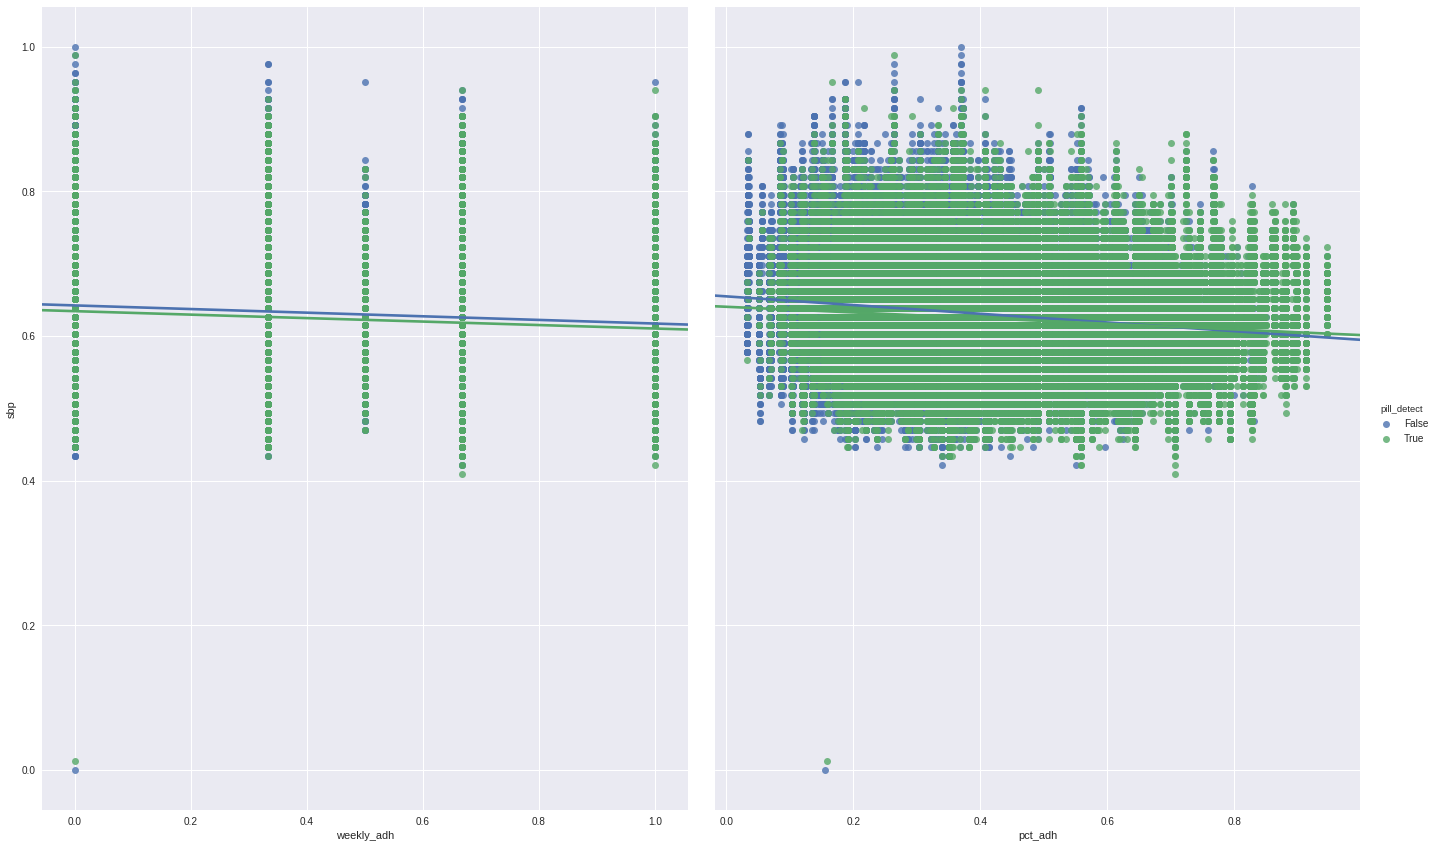

In [35]:
sns.pairplot(pdata, x_vars=["weekly_adh", "pct_adh"], y_vars=["sbp"],
             hue="pill_detect", size=12, aspect=.8, kind="reg");

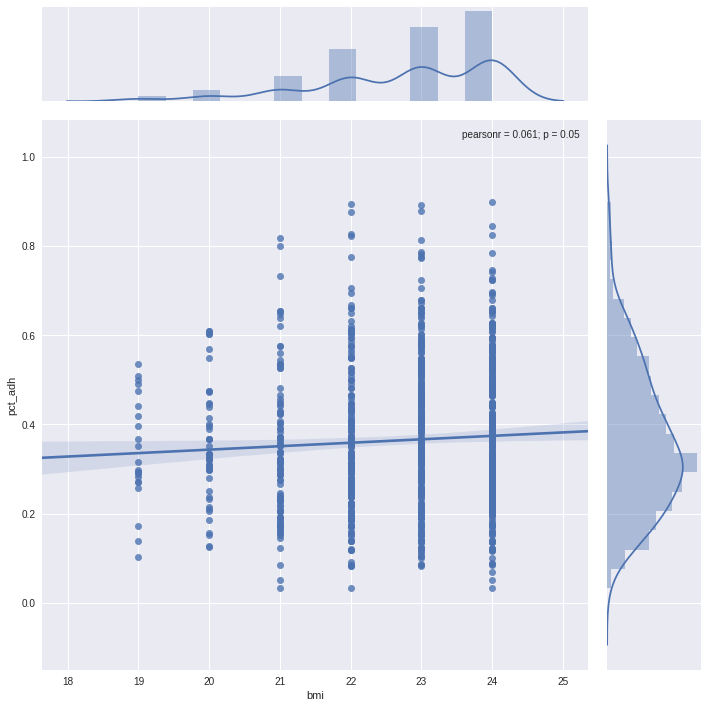

In [23]:
temp = pdata[(pdata["bmi"] < 25) & (pdata["bmi"] > 18)].groupby("user_id").mean().reset_index()
sns.jointplot(x='bmi', y='pct_adh',  data=temp, size=10,kind="reg")

In [24]:
interX_lm = ols("weekly_adh ~ gender", pdata.iloc[:,2:]).fit()
print(interX_lm.summary())

# Males have a better medical adherence level , but only by 7%. With statistical support

                            OLS Regression Results                            
Dep. Variable:             weekly_adh   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     5550.
Date:                Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                        03:01:55   Log-Likelihood:                -26229.
No. Observations:              250692   AIC:                         5.246e+04
Df Residuals:                  250690   BIC:                         5.248e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.3280      0.001    432.

In [25]:
pv_data = pdata.pivot(columns="user_id", index="date", values="sbp").reset_index()
pv_data.columns = pv_data.columns.astype(str)
pv_data = pv_data[7:] #ignore first 7 days 

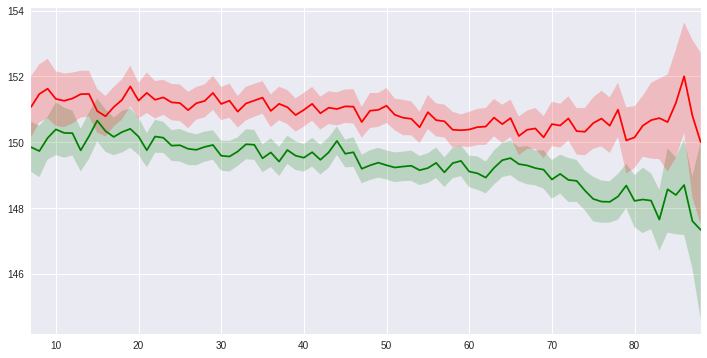

In [26]:
low_adhw = list(pdata[pdata["weekly_adh"] < 0.3].head(200).index) #low adheremce level
high_adhw = list(pdata[pdata["weekly_adh"] > 0.85].head(200).index) #high adherence levels

high_adhw = [str(i) for i in list(high_adh)]
low_adhw= [str(i) for i in list(low_adh)]

sns.set(rc={'figure.figsize':(12,6)})
## high vs low adherence groups 
sns.tsplot([pv_data[i] for i in high_adhw], time=pv_data.index, estimator=np.nanmean, color="green", ci=[80]) #high adherence >80
sns.tsplot([pv_data[i] for i in low_adhw], time=pv_data.index, estimator=np.nanmean, color="red",  ci=[80]) #low adherence <30

In [27]:
all_users = [str(i) for i in list(users.user_id)]
print(set(all_users) - set(pv_data.columns))
#all_users.remove('102951')


{'102951'}


### trends in adherence

In [28]:
pdata2 = pdata

pdata2.sbp = (pdata2.sbp - pdata2.sbp.min())/(pdata2.sbp.max() - pdata2.sbp.min() )
pv_data0 = pdata2.pivot(columns="user_id", index="date", values="sbp").reset_index()
pv_data0 = pv_data0[7:]
pv_data0.columns = pv_data0.columns.astype(str)
pv_data0.set_index("date", inplace=True)
pv_data0.index = pd.to_datetime(pv_data0.index)

all_users = [str(i) for i in list(pv_data0.columns)]
pv_data1 = pdata2.pivot(columns="user_id", index="date", values="weekly_adh").reset_index()
pv_data1 = pv_data1[7:]
pv_data1.columns = pv_data1.columns.astype(str)
#pv_data1.set_index("date", inplace=True)
pv_data1.index = pd.to_datetime(pv_data1.index)


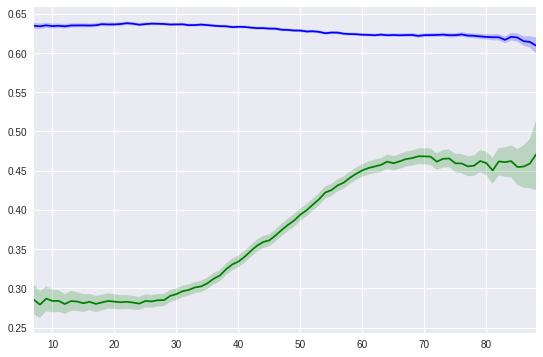

In [29]:
sns.set(rc={'figure.figsize':(9,6)})
sns.tsplot([pv_data1[i] for i in all_users], time=pv_data1.index, estimator=np.nanmean, color="green",  ci=[95]) #overall bp
sns.tsplot([pv_data0[i] for i in all_users], time=pv_data1.index, estimator=np.nanmean, color="blue",  ci=[95]) 

In [30]:
#resample and reduce the window to 3 for adherence 

In [31]:
temp = pdata.groupby(by="user_id")['pill_detect'].apply(lambda x: x.shift().rolling(min_periods=1,window=3).mean()).reset_index(name="weekly_adh")
pdata["weekly_adh"] = temp["weekly_adh"] 

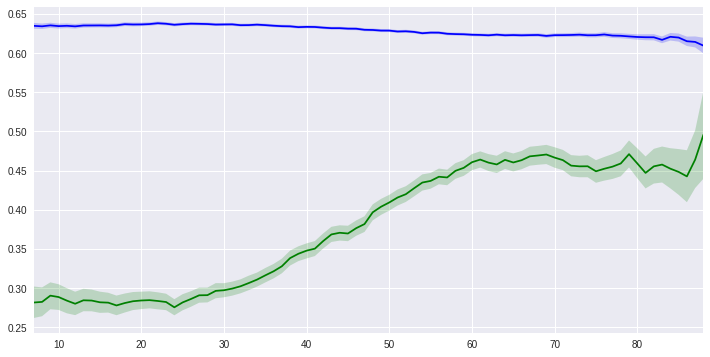

In [32]:
pdata2 = pdata

pdata2.sbp = (pdata2.sbp - pdata2.sbp.min())/(pdata2.sbp.max() - pdata2.sbp.min() )
pv_data0 = pdata2.pivot(columns="user_id", index="date", values="sbp").reset_index()
pv_data0 = pv_data0[7:]
pv_data0.columns = pv_data0.columns.astype(str)
pv_data0.set_index("date", inplace=True)
pv_data0.index = pd.to_datetime(pv_data0.index)

all_users = [str(i) for i in list(pv_data0.columns)]
pv_data1 = pdata2.pivot(columns="user_id", index="date", values="weekly_adh").reset_index()
pv_data1 = pv_data1[7:]
pv_data1.columns = pv_data1.columns.astype(str)
#pv_data1.set_index("date", inplace=True)
pv_data1.index = pd.to_datetime(pv_data1.index)
sns.set(rc={'figure.figsize':(12,6)})
sns.tsplot([pv_data1[i] for i in all_users], time=pv_data1.index, estimator=np.nanmean, color="green",  ci=[95]) #overall bp
sns.tsplot([pv_data0[i] for i in all_users], time=pv_data1.index, estimator=np.nanmean, color="blue",  ci=[95]) 

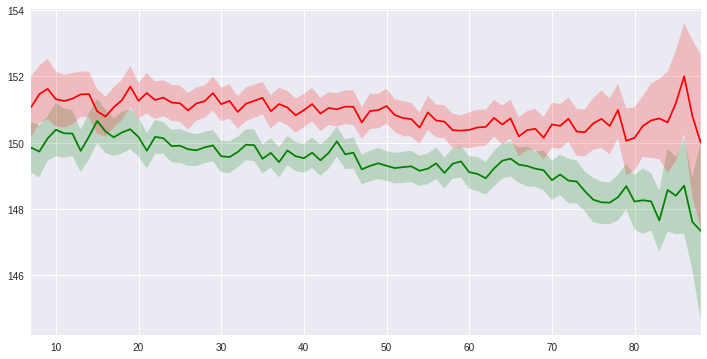

In [33]:
sns.tsplot([pv_data[i] for i in high_adhw], time=pv_data.index, estimator=np.nanmean, color="green", ci=[80]) #high adherence >80
sns.tsplot([pv_data[i] for i in low_adhw], time=pv_data.index, estimator=np.nanmean, color="red",  ci=[80]) #low adherence <30